### Выбор Retrieval подхода для последующего построения саммари

In [1]:
! pip install scikit-learn rank_bm25

Looking in indexes: https://artifactory.tcsbank.ru/artifactory/api/pypi/python-all/simple

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [3]:
import os, torch, gc
print("PID:", os.getpid())
print("allocated GB:", torch.cuda.memory_allocated()/1024**3)
print("reserved  GB:", torch.cuda.memory_reserved()/1024**3)


PID: 3414
allocated GB: 0.0
reserved  GB: 0.0


In [4]:
import pandas as pd

df = pd.read_csv("../data/cleaned_news_exp.csv")[["message_id", "id_channel", "message", "date", "topic", "viral_final"]]
df.head()

,message_id,id_channel,message,date,topic,viral_final
0,0007e2f8-787d-404f-91ff-e2582096a4a7,18,Сербия согласна поддержать санкции Евросоюза п...,2025-07-26 07:01:09,Санкции и геополитика,0.703622
1,000884a5-8291-4ec1-805f-ac131112aaf7,6,Китайский рынок акций упал сильнее всего с апр...,2025-09-04 10:16:56,Рынки капитала,0.680369
2,000b0331-92a9-4eb4-9f58-d00811257758,18,Министерство труда США отменило рекомендации 2...,2025-05-29 04:05:09,Государственная экономическая политика,0.589152
3,000b8df7-d902-41eb-b668-900614902f0a,6,Чистая прибыль Московской биржи по МСФО во вто...,2025-08-26 11:40:55,Корпоративные финансы,0.461692
4,0011adea-7a98-4dcc-b753-905597b42788,4,"США хотят получить нефть и «всё, что угодно» о...",2025-02-22 20:57:18,Сырьевые рынки,0.504362


In [5]:
df[df["message_id"] == "588a6960-aa5b-406b-8417-fdad3ccde1e9"].iloc[0]["message"]

'Кофе в России может подорожать на 50% уже в этом году, предупреждают аналитики Last Wish. Причины — засуха в Бразилии, рост логистических расходов, дефицит запасов и разбалансировка мирового спроса. Больше всего прибавит в цене арабика.\n\n🔵 Bloomberg'

In [6]:
import re
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple

In [7]:
def ensure_datetime(df: pd.DataFrame, col: str = "date") -> pd.DataFrame:
    d = df.copy()
    d[col] = pd.to_datetime(d[col], utc=True, errors="coerce")
    d = d.dropna(subset=[col])
    d["date_day"] = d[col].dt.floor("D")
    return d

def normalize_text(s: str) -> str:
    s = s or ""
    s = re.sub(r"\s+", " ", s).strip()
    return s

def l2_normalize(x: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    n = np.linalg.norm(x, axis=1, keepdims=True)
    return x / np.maximum(n, eps)

def cosine_scores(query_vec: np.ndarray, doc_mat_l2: np.ndarray) -> np.ndarray:
    q = l2_normalize(query_vec.reshape(1, -1))[0]
    return doc_mat_l2 @ q

def topk_from_scores(scores: np.ndarray, k: int) -> Tuple[np.ndarray, np.ndarray]:
    k = min(k, len(scores))
    if k == len(scores):
        idx = np.argsort(-scores)
    else:
        idx = np.argpartition(-scores, kth=k-1)[:k]
        idx = idx[np.argsort(-scores[idx])]
    return idx, scores[idx]

In [8]:
import numpy as np
from sentence_transformers import SentenceTransformer
from pathlib import Path

_E5_MODEL_NAME = "intfloat/multilingual-e5-large"
_e5_model = None

def _get_e5():
    global _e5_model
    if _e5_model is None:
        _e5_model = SentenceTransformer(_E5_MODEL_NAME)
    return _e5_model

class Encoder:
    def __init__(self, default_prefix: str = "query: "):
        self.default_prefix = default_prefix

    def _ensure_prefix(self, t: str) -> str:
        t = t or ""
        if t.startswith("query:") or t.startswith("passage:"):
            return t
        return (self.default_prefix + t) if self.default_prefix else t

    def encode_texts(self, texts):
        mod = _get_e5()
        texts = [self._ensure_prefix(x) for x in texts]
        vecs = mod.encode(texts, normalize_embeddings=True, show_progress_bar=False)
        return vecs.astype(np.float32)

def encode_query(query_text: str) -> np.ndarray:
    enc = Encoder(default_prefix="query: ")
    return enc.encode_texts([query_text])[0]


def load_and_normalize_emb(path: Path) -> np.ndarray:
    E = np.load(path, mmap_mode="r")
    X = E.astype(np.float32)
    X /= (np.linalg.norm(X, axis=1, keepdims=True) + 1e-12)
    return X

E_docs = load_and_normalize_emb(Path("embeddings/emb_e5_large_fp16.npy"))
encoder = Encoder(default_prefix="query: ")


## Semantic retrieve

In [9]:
from typing import Tuple, Optional
import pandas as pd
import numpy as np

def semantic_retrieve(
    df: pd.DataFrame,
    E_docs_l2: np.ndarray,
    query: str,
    encoder: Encoder,
    k: int = 200,
    end_date: Optional[pd.Timestamp] = None,
) -> pd.DataFrame:
    
    d = ensure_datetime(df, "date")
    if end_date is None:
        end_date = d["date_day"].max()
    end_date = pd.to_datetime(end_date, utc=True)
    idx_pool = np.arange(len(d))

    qv = encoder.encode_texts([f"query: {query}"])[0]
    scores = cosine_scores(qv, E_docs_l2[idx_pool])
    local_idx, local_scores = topk_from_scores(scores, k=min(k, len(idx_pool)))
    glob_idx = idx_pool[local_idx]

    out = d.iloc[glob_idx].copy()
    out["sim"] = local_scores
    return out.sort_values("sim", ascending=False).reset_index(drop=True)

In [10]:
cand = semantic_retrieve(
    df=df,
    E_docs_l2=E_docs,
    query="Кофе в России может подорожать на 50% уже в этом году, предупреждают аналитики Last Wish. Причины — засуха в Бразилии, рост логистических расходов, дефицит запасов и разбалансировка мирового спроса. Больше всего прибавит в цене арабика.\n\n🔵 Bloomberg",
    encoder=encoder,
    k=200,
)

cand[["date_day","id_channel","message_id","sim","message", "topic"]].head(20)


,date_day,id_channel,message_id,sim,message,topic
0,2025-04-07 00:00:00+00:00,5,588a6960-aa5b-406b-8417-fdad3ccde1e9,0.945688,Кофе в России может подорожать на 50% уже в эт...,Сырьевые рынки
1,2025-03-24 00:00:00+00:00,4,4f13a7ff-e768-43ef-a71b-e429f3dada1b,0.880965,Кофе может резко подорожать до 40% уже в этом ...,Сырьевые рынки
2,2025-08-01 00:00:00+00:00,5,8fbc1ae5-130c-4773-ba34-5e004af5861e,0.879588,В России ожидается новое подорожание кофе — на...,Сырьевые рынки
3,2025-07-10 00:00:00+00:00,4,5498bb88-6944-4a0b-9a19-324fc0b16c2e,0.879148,Кофе подорожает на 40% в этом году — прогноз э...,Сырьевые рынки
4,2025-03-24 00:00:00+00:00,5,6ba48c2b-b64b-4326-aa39-05ebd207ca59,0.871201,Россиян предупредили о резком скачке цен на ко...,Сырьевые рынки
5,2025-01-30 00:00:00+00:00,5,746d754f-a71f-4717-a59c-a0601ac0fe16,0.863449,Цены на кофе в России подскочат ещё на 20% уже...,Сырьевые рынки
6,2025-01-30 00:00:00+00:00,6,947db7a2-0784-4980-8ef5-8b2f7d2bca9c,0.859806,Крупнейшие поставщики собираются увеличить отп...,Сырьевые рынки
7,2025-03-04 00:00:00+00:00,4,52e1439a-fe85-4305-a407-0bfc2b873efa,0.857452,Кофе рекордно подорожает на 30-40% уже к концу...,Сырьевые рынки
8,2025-03-17 00:00:00+00:00,4,a6a9c0a2-93e7-40ee-b84f-92ae43a515be,0.852232,Чай резко подорожает в России до 40% уже в 202...,Сырьевые рынки
9,2025-01-09 00:00:00+00:00,18,f7212d03-4fc9-4c70-b58c-bfb3336ff4ca,0.850911,Цены на кофе и шоколад в этом году взлетят на ...,Сырьевые рынки


## BM25 retrieve

In [11]:
from typing import Optional
import numpy as np
import pandas as pd
import re
from rank_bm25 import BM25Okapi

def _tok(s: str):
    return re.findall(r"[A-Za-zА-Яа-яЁё0-9_]+", (s or "").lower())

def build_bm25_index(df: pd.DataFrame, text_col: str = "message"):
    texts = df[text_col].fillna("").astype(str).tolist()
    tokenized = [_tok(t) for t in texts]
    bm25 = BM25Okapi(tokenized)
    return bm25

def bm25_retrieve(
    df: pd.DataFrame,
    bm25,
    query: str,
    k: int = 200,
    end_date: Optional[pd.Timestamp] = None,
) -> pd.DataFrame:
    d = ensure_datetime(df, "date")
    if "channel" not in d.columns and "id_channel" in d.columns:
        d = d.rename(columns={"id_channel": "channel"})
    if end_date is None:
        end_date = d["date_day"].max()
    end_date = pd.to_datetime(end_date, utc=True)

    idx_pool = np.arange(len(d))

    q = _tok(query)
    scores_full = np.asarray(bm25.get_scores(q), dtype=np.float32)
    scores = scores_full[idx_pool]
    local_idx, local_scores = topk_from_scores(scores, k=min(k, len(idx_pool)))
    glob_idx = idx_pool[local_idx]

    out = d.iloc[glob_idx].copy()
    out["bm25"] = local_scores
    return out.sort_values("bm25", ascending=False).reset_index(drop=True)

In [12]:
bm25 = build_bm25_index(df, text_col="message")
cand_bm25 = bm25_retrieve(df, bm25, "Кофе в России может подорожать на 50% уже в этом году, предупреждают аналитики Last Wish. Причины — засуха в Бразилии, рост логистических расходов, дефицит запасов и разбалансировка мирового спроса. Больше всего прибавит в цене арабика.\n\n🔵 Bloomberg", k=200)
cand_bm25[["date_day","channel","message_id","bm25","message", "topic"]].head(20)

,date_day,channel,message_id,bm25,message,topic
0,2025-04-07 00:00:00+00:00,5,588a6960-aa5b-406b-8417-fdad3ccde1e9,200.892044,Кофе в России может подорожать на 50% уже в эт...,Сырьевые рынки
1,2025-03-24 00:00:00+00:00,4,4f13a7ff-e768-43ef-a71b-e429f3dada1b,82.025490,Кофе может резко подорожать до 40% уже в этом ...,Сырьевые рынки
2,2025-03-24 00:00:00+00:00,5,6ba48c2b-b64b-4326-aa39-05ebd207ca59,62.448727,Россиян предупредили о резком скачке цен на ко...,Сырьевые рынки
3,2025-05-31 00:00:00+00:00,5,e34759e9-a8c9-48e8-8ac0-e9fafdfa74a4,49.746479,Бензин в России начнёт дорожать в два раза быс...,Сырьевые рынки
4,2025-01-09 00:00:00+00:00,18,f7212d03-4fc9-4c70-b58c-bfb3336ff4ca,49.626266,Цены на кофе и шоколад в этом году взлетят на ...,Сырьевые рынки
5,2025-06-16 00:00:00+00:00,3,d009f7ce-5386-4530-a117-f8c70c23288f,48.738232,Кофе и какао в мире могут подорожать из-за тор...,Сырьевые рынки
6,2025-08-14 00:00:00+00:00,18,1c2253b9-4b34-44bd-9ddf-1d290c6fa513,47.065208,Международное энергетическое агентство снизило...,Сырьевые рынки
7,2025-03-17 00:00:00+00:00,5,0ee0c3ae-98e7-4dbb-b1f9-8ce34c26b616,46.789661,"Чай подорожает в 2025 году. Элитные сорта, вкл...",Другое
8,2025-08-30 00:00:00+00:00,1,a1899d8e-2f4c-4b11-848c-c95f8465c106,46.733784,По итогам августа пиломатериалы и медь больше ...,Сырьевые рынки
9,2025-07-11 00:00:00+00:00,6,9f0c4216-c0f7-4d9d-99e5-d89705495053,45.063896,Повышение до 50% импортных пошлин США на товар...,Государственная экономическая политика


## Hybrid

In [13]:
from typing import Optional
import numpy as np
import pandas as pd

def rrf_fuse_weighted(sem_idx, bm_idx, k_rrf=60, w_sem=1.0, w_bm=1.0):
    scores = {}
    for w, rank in ((w_sem, sem_idx), (w_bm, bm_idx)):
        for i, doc_id in enumerate(rank):
            scores[doc_id] = scores.get(doc_id, 0.0) + w * (1.0 / (k_rrf + i + 1))
    ids = np.array(sorted(scores.keys(), key=lambda x: -scores[x]), dtype=int)
    vals = np.array([scores[i] for i in ids], dtype=np.float32)
    return ids, vals


def hybrid_retrieve(
    df: pd.DataFrame,
    E_docs_l2: np.ndarray,
    bm25,
    query: str,
    encoder: Encoder,
    k: int = 200,
    topN_each: int = 1000,
    k_rrf: int = 60,
    w_sem: float = 1.0,
    w_bm: float = 1.0,
    end_date: Optional[pd.Timestamp] = None,
) -> pd.DataFrame:
    d = ensure_datetime(df, "date")
    if "channel" not in d.columns and "id_channel" in d.columns:
        d = d.rename(columns={"id_channel": "channel"})
    if end_date is None:
        end_date = d["date_day"].max()
    end_date = pd.to_datetime(end_date, utc=True)

    idx_pool = np.arange(len(d))

    qv = encoder.encode_texts([f"query: {query}"])[0]
    sem_scores = cosine_scores(qv, E_docs_l2[idx_pool])
    sem_local, _ = topk_from_scores(sem_scores, k=min(topN_each, len(idx_pool)))
    sem_rank = idx_pool[sem_local].tolist()

    q = _tok(query)
    bm_scores_full = np.asarray(bm25.get_scores(q), dtype=np.float32)
    bm_scores = bm_scores_full[idx_pool]
    bm_local, _ = topk_from_scores(bm_scores, k=min(topN_each, len(idx_pool)))
    bm_rank = idx_pool[bm_local].tolist()

    fused_ids, fused_scores = rrf_fuse_weighted(
        sem_rank, bm_rank, k_rrf=k_rrf, w_sem=w_sem, w_bm=w_bm
    )
    fused_ids = fused_ids[:min(k, len(fused_ids))]
    fused_scores = fused_scores[:len(fused_ids)]

    out = d.iloc[fused_ids].copy()
    out["rrf"] = fused_scores
    out["sem_sim"] = cosine_scores(qv, E_docs_l2[fused_ids])
    out["bm25"] = bm_scores_full[fused_ids]
    return out.sort_values("rrf", ascending=False).reset_index(drop=True)



In [14]:
cand_h = hybrid_retrieve(
    df=df,
    E_docs_l2=E_docs,
    bm25=bm25,
    query="Кофе в России может подорожать на 50% уже в этом году, предупреждают аналитики Last Wish. Причины — засуха в Бразилии, рост логистических расходов, дефицит запасов и разбалансировка мирового спроса. Больше всего прибавит в цене арабика.\n\n🔵 Bloomberg",
    encoder=encoder,
    k=200,
    topN_each=2000,
    k_rrf=10,
    w_sem=1.2,
    w_bm=0.5,
)


cand_h[["date_day","channel","message_id","rrf","sem_sim","bm25","message", "topic"]].head(20)

,date_day,channel,message_id,rrf,sem_sim,bm25,message,topic
0,2025-04-07 00:00:00+00:00,5,588a6960-aa5b-406b-8417-fdad3ccde1e9,0.154545,0.945688,200.892044,Кофе в России может подорожать на 50% уже в эт...,Сырьевые рынки
1,2025-03-24 00:00:00+00:00,4,4f13a7ff-e768-43ef-a71b-e429f3dada1b,0.141667,0.880965,82.025490,Кофе может резко подорожать до 40% уже в этом ...,Сырьевые рынки
2,2025-03-24 00:00:00+00:00,5,6ba48c2b-b64b-4326-aa39-05ebd207ca59,0.118462,0.871201,62.448727,Россиян предупредили о резком скачке цен на ко...,Сырьевые рынки
3,2025-08-01 00:00:00+00:00,5,8fbc1ae5-130c-4773-ba34-5e004af5861e,0.113141,0.879588,43.442513,В России ожидается новое подорожание кофе — на...,Сырьевые рынки
4,2025-07-10 00:00:00+00:00,4,5498bb88-6944-4a0b-9a19-324fc0b16c2e,0.100866,0.879148,40.782764,Кофе подорожает на 40% в этом году — прогноз э...,Сырьевые рынки
5,2025-01-30 00:00:00+00:00,5,746d754f-a71f-4717-a59c-a0601ac0fe16,0.096739,0.863449,43.555683,Цены на кофе в России подскочат ещё на 20% уже...,Сырьевые рынки
6,2025-01-09 00:00:00+00:00,18,f7212d03-4fc9-4c70-b58c-bfb3336ff4ca,0.093333,0.850911,49.626266,Цены на кофе и шоколад в этом году взлетят на ...,Сырьевые рынки
7,2025-06-16 00:00:00+00:00,3,d009f7ce-5386-4530-a117-f8c70c23288f,0.081250,0.843620,48.738232,Кофе и какао в мире могут подорожать из-за тор...,Сырьевые рынки
8,2025-01-30 00:00:00+00:00,6,947db7a2-0784-4980-8ef5-8b2f7d2bca9c,0.076686,0.859806,35.191982,Крупнейшие поставщики собираются увеличить отп...,Сырьевые рынки
9,2025-04-19 00:00:00+00:00,3,ce0ff05d-0916-4fd0-b197-b7b9e5fcc923,0.075983,0.844805,44.961369,Колумбийский эксперт и бариста Себастьян Сулуа...,Сырьевые рынки


## Посравниваем

In [15]:
import json, re, torch
from transformers import AutoTokenizer, AutoModelForCausalLM

JUDGE_MODEL = "Qwen/Qwen2.5-7B-Instruct"

judge_tokenizer = AutoTokenizer.from_pretrained(JUDGE_MODEL, trust_remote_code=True)
judge_model = AutoModelForCausalLM.from_pretrained(
    JUDGE_MODEL,
    torch_dtype=torch.bfloat16,
    device_map="cuda",
    trust_remote_code=True,
)
judge_model.eval()

def _extract_first_json_obj(text: str):
    text = (text or "").strip()
    if text.startswith("{") and text.endswith("}"):
        try:
            return json.loads(text)
        except Exception:
            pass
    for m in re.finditer(r"\{.*?\}", text, flags=re.DOTALL):
        cand = m.group(0)
        try:
            return json.loads(cand)
        except Exception:
            continue
    return None


@torch.inference_mode()
def judge_pairs_batched(pairs, batch_size=32, max_new_tokens=40):
    out_scores = []
    for i in range(0, len(pairs), batch_size):
        chunk = pairs[i:i+batch_size]

        prompts = []
        for q, sn in chunk:
            user = f"Запрос:\n{q}\n\nДокумент:\n{sn}\n"
            messages = [
                {"role": "system", "content": JUDGE_SYSTEM},
                {"role": "user", "content": user},
            ]
            prompts.append(
                judge_tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
            )

        enc = judge_tokenizer(
            prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
        ).to(judge_model.device)

        gen_ids = judge_model.generate(
            **enc,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            eos_token_id=judge_tokenizer.eos_token_id,
            pad_token_id=judge_tokenizer.eos_token_id,
        )

        for b in range(len(chunk)):
            prompt_len = int(enc["attention_mask"][b].sum().item())
            gen_txt = judge_tokenizer.decode(gen_ids[b][prompt_len:], skip_special_tokens=True)
            data = _extract_first_json_obj(gen_txt)
            rel = int(data["relevance"]) if isinstance(data, dict) and data.get("relevance") in (0,1,2) else 0
            out_scores.append(rel)

    return out_scores

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [16]:
JUDGE_SYSTEM = """Ты — строгий эксперт по информационному поиску по новостям (в т.ч. экономическим).

Твоя задача: оценить релевантность кандидатной новости запросу. Запрос может быть:
- коротким топиком (например "курс рубля к доллару"),
- или текстом другой новости (тогда запрос описывает конкретный инфоповод).

Используй ТОЛЬКО текст кандидатного документа. Ничего не додумывай.

Шкала релевантности:
2 — документ явно про то же самое: отвечает топику ИЛИ описывает тот же инфоповод/факт/событие, что и запрос.
1 — документ связан по теме/контексту, но это немного другой инфоповод, но про одно и то же или нет прямого соответствия запросу.
0 — нерелевантно совсем.

Правило строгости:
ставь 2 только если связь очевидна по тексту документа; если информации недостаточно — ставь 0 или 1.

Верни строго валидный JSON и ничего больше:
{"relevance": 0|1|2}
"""


In [17]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm

K = 50
SEED = 42
N_MANUAL = 20
N_AUTO = 20

manual_queries = list(dict.fromkeys([
    "рост цен на кофе",
    "ключевая ставка цб решение",
    "повышение ключевой ставки",
    "снижение ключевой ставки",
    "инфляция ускорилась",
    "инфляция замедлилась",
    "индекс потребительских цен ипц",
    "курс рубля к доллару",
    "курс евро к рублю",
    "ослабление рубля причины",
    "нефть brent падение",
    "нефть brent рост",
    "цена нефти brent прогноз",
    "газ в европе цены",
    "газ в европе прогноз",
    "мосбиржа индекс imoex рост",
    "мосбиржа индекс imoex падение",
    "санкции влияние на экономику",
    "санкции против россии новые",
    "ограничения на экспорт влияние",
]))

def clean_auto_query(t: str) -> str:
    t = re.sub(r"#\w+", " ", t)
    t = re.sub(r"[⚡️📈📉🇷🇺✅❗️🔥⬛ ⬜ ⚫ ⚪🔹]+", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t[:180]

def snippet(t: str, n: int = 800) -> str:
    t = re.sub(r"\s+", " ", (t or "").strip())
    return t[:n]

def dcg(rels):
    rels = np.array(rels, dtype=float)
    denom = np.log2(np.arange(2, len(rels) + 2))
    return float(np.sum((2**rels - 1) / denom))

def ndcg_at_k(rels, k=50):
    rels = list(rels)[:k]
    ideal = sorted(rels, reverse=True)
    denom = dcg(ideal)
    return 0.0 if denom == 0 else dcg(rels) / denom

def precision_at_k(rels, k=50, thr=1):
    rels = np.array(list(rels)[:k])
    return float(np.mean(rels >= thr)) if len(rels) else 0.0

def mrr_at_k(rels, k=50, thr=2):
    rels = list(rels)[:k]
    for i, r in enumerate(rels, start=1):
        if r >= thr:
            return 1.0 / i
    return 0.0


FULL_QUERY_CHARS = 1500

def clean_auto_query_full(t: str, n: int = FULL_QUERY_CHARS) -> str:
    t = re.sub(r"#\w+", " ", t)
    t = re.sub(r"[⚡️📈📉🇷🇺✅❗️🔥⬛⬜⚫⚪🔹]+", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t[:n]

rng = np.random.default_rng(SEED)

pool_df = df.copy()
pool_df["message"] = pool_df["message"].fillna("").astype(str)
pool_df = pool_df[pool_df["message"].str.len() >= 80]

sample = pool_df.sample(n=min(N_AUTO, len(pool_df)), random_state=SEED)

auto_queries = []
for _, row in sample.iterrows():
    auto_queries.append({
        "type": "news",
        "text": clean_auto_query_full(row["message"], n=FULL_QUERY_CHARS),
        "exclude_message_id": str(row["message_id"]),
    })

manual_q = [
    {"type": "topic", "text": q, "exclude_message_id": None}
    for q in manual_queries[:N_MANUAL]
]

queries = manual_q + auto_queries
queries = queries[: (N_MANUAL + N_AUTO)]

len(queries), queries


(40,
 [{'type': 'topic', 'text': 'рост цен на кофе', 'exclude_message_id': None},
  {'type': 'topic',
   'text': 'ключевая ставка цб решение',
   'exclude_message_id': None},
  {'type': 'topic',
   'text': 'повышение ключевой ставки',
   'exclude_message_id': None},
  {'type': 'topic',
   'text': 'снижение ключевой ставки',
   'exclude_message_id': None},
  {'type': 'topic', 'text': 'инфляция ускорилась', 'exclude_message_id': None},
  {'type': 'topic',
   'text': 'инфляция замедлилась',
   'exclude_message_id': None},
  {'type': 'topic',
   'text': 'индекс потребительских цен ипц',
   'exclude_message_id': None},
  {'type': 'topic',
   'text': 'курс рубля к доллару',
   'exclude_message_id': None},
  {'type': 'topic', 'text': 'курс евро к рублю', 'exclude_message_id': None},
  {'type': 'topic',
   'text': 'ослабление рубля причины',
   'exclude_message_id': None},
  {'type': 'topic', 'text': 'нефть brent падение', 'exclude_message_id': None},
  {'type': 'topic', 'text': 'нефть brent р

In [18]:
def _take_top_docs(cand: pd.DataFrame, k: int):
    cand = cand.copy()
    if "channel" not in cand.columns and "id_channel" in cand.columns:
        cand = cand.rename(columns={"id_channel": "channel"})
    cand = cand.head(k)
    ids = cand["message_id"].astype(str).tolist()
    docs = [snippet(x) for x in cand["message"].fillna("").astype(str).tolist()]
    return ids, docs

def eval_three_retrievers(
    df: pd.DataFrame,
    E_docs: np.ndarray,
    encoder,
    bm25,
    queries,
    k: int = 50,
    topN_each: int = 1000,
    k_rrf: int = 60,
    w_sem: float = 1.0,
    w_bm: float = 1.0,
    batch_size: int = 32,
):
    metric_rows = []
    pair_rows = []

    for qobj in tqdm(queries, desc="Queries"):
        q = qobj["text"]
        q_type = qobj.get("type", "unknown")
        exclude_mid = qobj.get("exclude_message_id", None)

        q_for_judge = q

        cand_sem = semantic_retrieve(df, E_docs, q, encoder, k=k)
        cand_bm  = bm25_retrieve(df, bm25, q, k=k)
        cand_hyb = hybrid_retrieve(
            df, E_docs, bm25, q, encoder,
            k=k,
            topN_each=topN_each,
            k_rrf=k_rrf,
            w_sem=w_sem,
            w_bm=w_bm
        )

        packs = [("semantic", cand_sem), ("bm25", cand_bm), ("hybrid", cand_hyb)]

        for method, cand in packs:
            if exclude_mid is not None and "message_id" in cand.columns:
                cand = cand[cand["message_id"].astype(str) != str(exclude_mid)]

            ids, docs = _take_top_docs(cand, k)
            rels = judge_pairs_batched([(q_for_judge, d) for d in docs], batch_size=batch_size)

            metric_rows.append({
                "q_type": q_type,
                "query": q_for_judge,
                "method": method,
                "ndcg@50": ndcg_at_k(rels, k),
                "mrr@50(rel=2)": mrr_at_k(rels, k, thr=2),
                "p@50(rel=2)": precision_at_k(rels, k, thr=2),
                "p@50(rel>=1)": precision_at_k(rels, k, thr=1),
                "n_docs": len(rels),
            })

            for r, (mid, rel) in enumerate(zip(ids, rels), start=1):
                pair_rows.append({
                    "q_type": q_type,
                    "query": q_for_judge,
                    "method": method,
                    "rank": r,
                    "message_id": mid,
                    "relevance": int(rel),
                })

    return pd.DataFrame(metric_rows), pd.DataFrame(pair_rows)



metrics_df, pairs_df = eval_three_retrievers(
    df=df,
    E_docs=E_docs,
    encoder=encoder,
    bm25=bm25,
    queries=queries,
    k=50,
    topN_each=2000,
    k_rrf=60,
    w_sem=1.0,
    w_bm=1.0,
    batch_size=32,
)


Queries: 100%|██████████| 40/40 [08:21<00:00, 12.53s/it]


In [19]:
print("allocated:", torch.cuda.memory_allocated()/1024**3, "GB")
print("reserved :", torch.cuda.memory_reserved()/1024**3, "GB")


allocated: 16.279865741729736 GB
reserved : 24.306640625 GB


In [20]:
summary = metrics_df.groupby("method", as_index=False)[["ndcg@50","mrr@50(rel=2)","p@50(rel=2)","p@50(rel>=1)"]].mean()
summary

,method,ndcg@50,mrr@50(rel=2),p@50(rel=2),p@50(rel>=1)
0,bm25,0.739282,0.521766,0.195867,0.385082
1,hybrid,0.783114,0.593155,0.267857,0.469888
2,semantic,0.763042,0.572750,0.280347,0.484347


In [21]:
pivot_ndcg = metrics_df.pivot(index="query", columns="method", values="ndcg@50")
pivot_mrr  = metrics_df.pivot(index="query", columns="method", values="mrr@50(rel=2)")
pivot_p2   = metrics_df.pivot(index="query", columns="method", values="p@50(rel=2)")

win_ndcg = {
    "hybrid>semantic": float((pivot_ndcg["hybrid"] > pivot_ndcg["semantic"]).mean()),
    "hybrid>bm25": float((pivot_ndcg["hybrid"] > pivot_ndcg["bm25"]).mean()),
    "semantic>bm25": float((pivot_ndcg["semantic"] > pivot_ndcg["bm25"]).mean()),
}
win_mrr = {
    "hybrid>semantic": float((pivot_mrr["hybrid"] > pivot_mrr["semantic"]).mean()),
    "hybrid>bm25": float((pivot_mrr["hybrid"] > pivot_mrr["bm25"]).mean()),
    "semantic>bm25": float((pivot_mrr["semantic"] > pivot_mrr["bm25"]).mean()),
}
win_p2 = {
    "hybrid>semantic": float((pivot_p2["hybrid"] > pivot_p2["semantic"]).mean()),
    "hybrid>bm25": float((pivot_p2["hybrid"] > pivot_p2["bm25"]).mean()),
    "semantic>bm25": float((pivot_p2["semantic"] > pivot_p2["bm25"]).mean()),
}

win_ndcg, win_mrr, win_p2

({'hybrid>semantic': 0.525, 'hybrid>bm25': 0.75, 'semantic>bm25': 0.625},
 {'hybrid>semantic': 0.15, 'hybrid>bm25': 0.225, 'semantic>bm25': 0.225},
 {'hybrid>semantic': 0.175, 'hybrid>bm25': 0.525, 'semantic>bm25': 0.525})

In [22]:
by_type = (metrics_df
           .groupby(["q_type", "method"])[["ndcg@50","mrr@50(rel=2)","p@50(rel=2)","p@50(rel>=1)"]]
           .mean()
           .sort_index())
display(by_type)

ndcg@50  mrr@50(rel=2)  p@50(rel=2)  p@50(rel>=1)
q_type method                                                      
news   bm25      0.650798       0.329167     0.036735      0.158163
       hybrid    0.660490       0.287500     0.035714      0.188776
       semantic  0.612732       0.239251     0.034694      0.184694
topic  bm25      0.827766       0.714365     0.355000      0.612000
       hybrid    0.905737       0.898810     0.500000      0.751000
       semantic  0.913351       0.906250     0.526000      0.784000

### Выводы:
- Необходима дополнительная фильтрация на релевантность кандидатов
- hybrid показывает сопоставимые результаты с dense retrieval для топиков, но bm25 спасает при кандидатогенерации для текстов

Принято решение использовать гибрид

In [3]:
!pip install umap-learn

   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   --- ------------------------------------ 0.8/8.9 MB 3.7 MB/s eta 0:00:03
   ----------- ---------------------------- 2.6/8.9 MB 7.9 MB/s eta 0:00:01
   -------------------- ------------------- 4.5/8.9 MB 8.1 MB/s eta 0:00:01
   ------------------------- -------------- 5.8/8.9 MB 7.8 MB/s eta 0:00:01
   ------------------------------ --------- 6.8/8.9 MB 7.2 MB/s eta 0:00:01
   ----------------------------------- ---- 7.9/8.9 MB 6.6 MB/s eta 0:00:01
   -------------------------------------- - 8.7/8.9 MB 6.2 MB/s eta 0:00:01
   ---------------------------------------- 8.9/8.9 MB 5.9 MB/s  0:00:01

  Attempting uninstall: scikit-learn

    Found existing installation: scikit-learn 1.3.2

   ---------------------------------------- 0/3 [scikit-learn]
    Uninstalling scikit-learn-1.3.2:
   ---------------------------------------- 0/3 [scikit-learn]
      Successfully uninstalled scikit-learn-1.3.2
   ------------------

Считаем проекцию для Base...


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Считаем проекцию для Large...


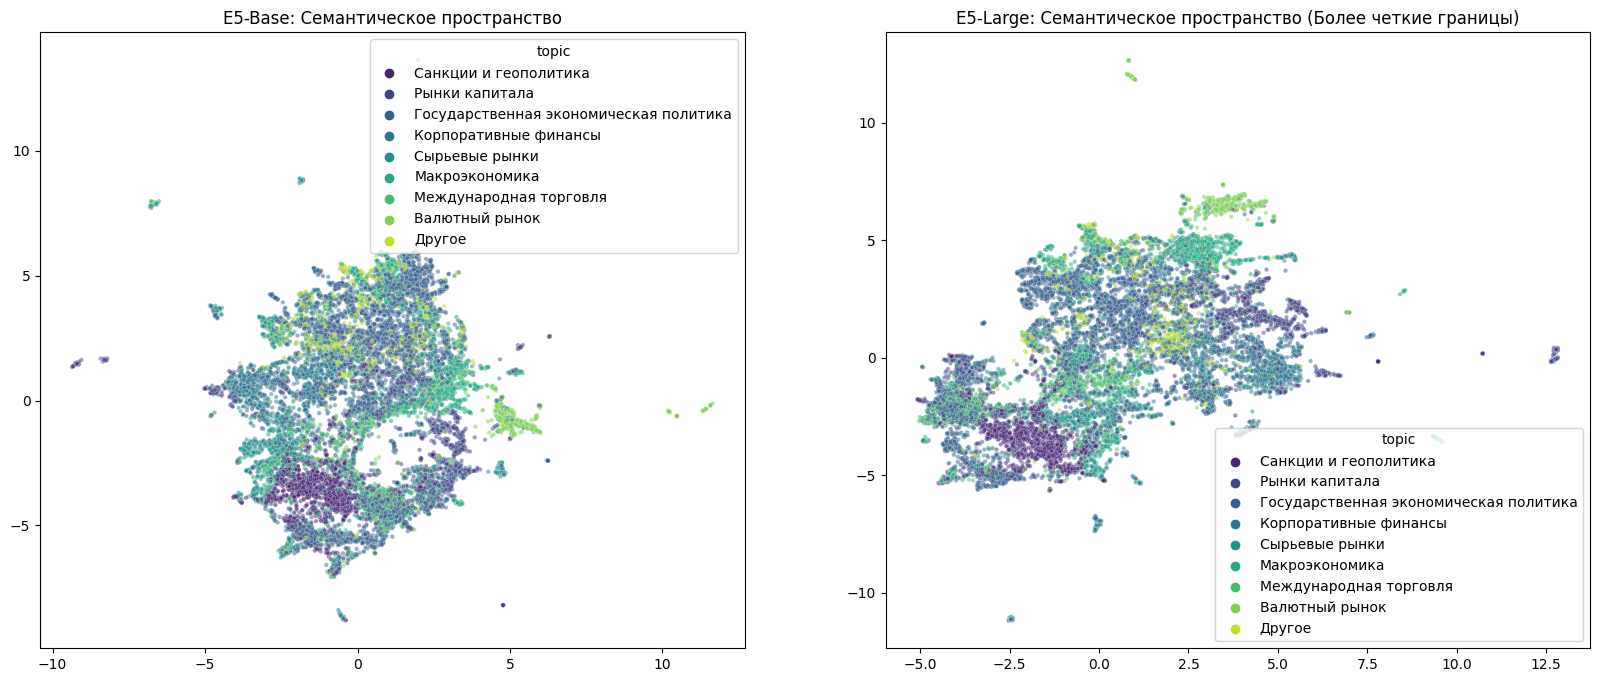

In [9]:
import numpy as np
import pandas as pd
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

# Подгружаем данные (замени пути на актуальные из папки проекта)
df_eval = pd.read_csv('..\\data\\cleaned_news_exp.csv')
emb_base = np.load('embeddings\emb_e5_base_fp16.npy').astype('float32') 
emb_large = np.load('embeddings\emb_e5_large_fp16.npy').astype('float32')

def plot_comparison(emb_b, emb_l, topics):
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
    
    print("Считаем проекцию для Base...")
    pro_base = reducer.fit_transform(emb_b)
    print("Считаем проекцию для Large...")
    pro_large = reducer.fit_transform(emb_l)
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    
    sns.scatterplot(x=pro_base[:, 0], y=pro_base[:, 1], hue=topics, ax=ax[0], palette='viridis', s=10, alpha=0.5)
    ax[0].set_title('E5-Base: Семантическое пространство')
    
    sns.scatterplot(x=pro_large[:, 0], y=pro_large[:, 1], hue=topics, ax=ax[1], palette='viridis', s=10, alpha=0.5)
    ax[1].set_title('E5-Large: Семантическое пространство (Более четкие границы)')
    
    plt.show()

plot_comparison(emb_base, emb_large, df_eval['topic'])

In [14]:
def analyze_margin(embeddings, test_idx, k=2):
    margins = []
    for idx in test_idx:
        query_vec = embeddings[idx].reshape(1, -1)
        # Считаем сходство со всеми
        sims = np.dot(embeddings, query_vec.T).flatten()
        top_2_idx = np.argsort(sims)[::-1][:k+1] # берем топ-3, т.к. топ-1 это сам документ
        
        # Margin = Сходство с самим собой (1.0) минус сходство со вторым кандидатом
        margin = sims[top_2_idx[0]] - sims[top_2_idx[1]]
        margins.append(margin)
    return np.mean(margins)

test_indices = df_eval.sample(100, random_state=42).index.tolist()

margin_base = analyze_margin(emb_base, test_indices)
margin_large = analyze_margin(emb_large, test_indices)

print(f"Средний разрыв (Margin) Base: {margin_base:.4f}")
print(f"Средний разрыв (Margin) Large: {margin_large:.4f}")

if margin_large > margin_base:
    print(f"\nВЫВОД: Large модель лучше, так как она более 'уверенно' отделяет правильный результат от похожих.")

Средний разрыв (Margin) Base: 0.0710
Средний разрыв (Margin) Large: 0.0764

ВЫВОД: Large модель лучше, так как она более 'уверенно' отделяет правильный результат от похожих.


Средний разрыв (Margin) Base: 0.0710
Средний разрыв (Margin) Large: 0.0764


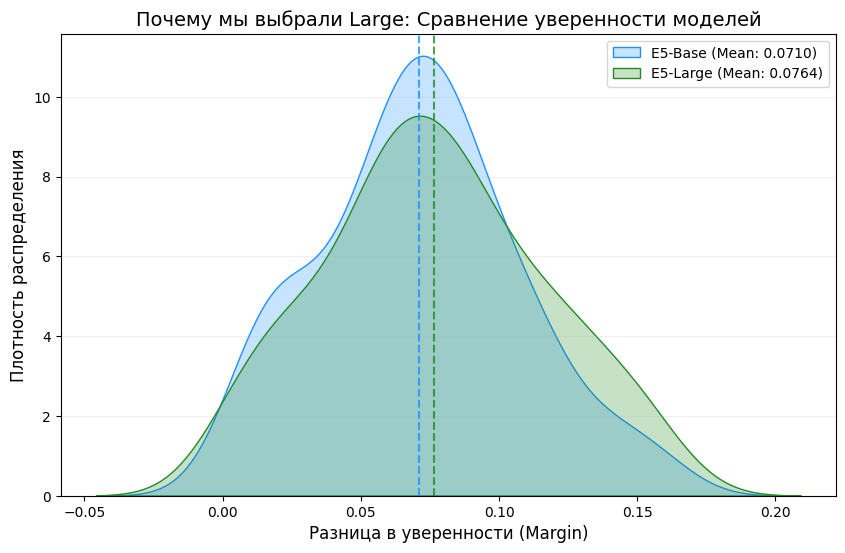

In [18]:
def analyze_margin(embeddings, test_idx, k=2):
    margins = []
    for idx in test_idx:
        query_vec = embeddings[idx].reshape(1, -1)
        sims = np.dot(embeddings, query_vec.T).flatten()
        top_2_idx = np.argsort(sims)[::-1][:k+1] 
        
        # Разрыв между самым похожим (обычно это сам документ) и вторым кандидатом
        margin = sims[top_2_idx[0]] - sims[top_2_idx[1]]
        margins.append(margin)
    
    # Возвращаем кортеж: (среднее значение, весь список значений)
    return np.mean(margins), margins

test_indices = df_eval.sample(100, random_state=42).index.tolist()

# Распаковываем результат в две переменные для каждой модели
margin_base_avg, margins_base_list = analyze_margin(emb_base, test_indices)
margin_large_avg, margins_large_list = analyze_margin(emb_large, test_indices)

print(f"Средний разрыв (Margin) Base: {margin_base_avg:.4f}")
print(f"Средний разрыв (Margin) Large: {margin_large_avg:.4f}")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 6))

# Рисуем распределение на основе полных списков
sns.kdeplot(margins_base_list, fill=True, label=f'E5-Base (Mean: {margin_base_avg:.4f})', color='dodgerblue')
sns.kdeplot(margins_large_list, fill=True, label=f'E5-Large (Mean: {margin_large_avg:.4f})', color='forestgreen')

# Добавляем вертикальные линии средних значений
plt.axvline(margin_base_avg, color='dodgerblue', linestyle='--', alpha=0.8)
plt.axvline(margin_large_avg, color='forestgreen', linestyle='--', alpha=0.8)

plt.title('Почему мы выбрали Large: Сравнение уверенности моделей', fontsize=14)
plt.xlabel('Разница в уверенности (Margin)', fontsize=12)
plt.ylabel('Плотность распределения', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.2)
plt.show()

===============================================================================

In [22]:
!pip install sentence-transformers

In [24]:
!pip uninstall -y torch torchvision torchaudio
!pip install torch --index-url https://download.pytorch.org/whl/cpu

Found existing installation: torch 2.9.1
Uninstalling torch-2.9.1:
  Successfully uninstalled torch-2.9.1


Looking in indexes: https://download.pytorch.org/whl/cpu
   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/110.9 MB ? eta -:--:--
   ---------------------------------------- 0.5/110.9 MB 1.2 MB/s eta 0:01:33
   ---------------------------------------- 0.8/110.9 MB 1.2 MB/s eta 0:01:36
   ---------------------------------------- 1.0/110.9 MB 1.1 MB/s eta 0:01:41
   ---------------------------------------- 1.3/110.9 MB 1.1 MB/s eta 0:01:40
    --------------------------------------- 1.6/110.9 MB 1.1 MB/s eta 0:01:42
    --------------------------------------- 1.6/110.9 MB 1.1 MB/s eta 0:01:42
    --------------------------------------- 1.8/110.9 MB 1.0 MB/s eta 0:01:47
    --------------------------------------- 1.8/110.9 MB 1.0 MB/s eta 0:01:47
    --------------------------------------- 1.8/110.9 MB 1.0 MB/s eta 0:01:47
    ------------------------

In [1]:
import torch
print(f"Torch version: {torch.__version__}")
# Если это выведет версию без ошибки, значит CrossEncoder заработает!

from sentence_transformers import CrossEncoder
print("Успех! Библиотека загружена.")

Torch version: 2.9.1+cpu
Успех! Библиотека загружена.


In [3]:
from sentence_transformers import CrossEncoder
import numpy as np
from tqdm.auto import tqdm

# 1. Загружаем модель-реранкер
# bge-reranker-v2-m3 — одна из лучших для русского и финансовых текстов
print("Загрузка модели реранкера...")
reranker = CrossEncoder('BAAI/bge-reranker-v2-m3') 

def get_reranked_top_k(query, candidate_docs, k=5):
    if not candidate_docs:
        return [], []
    
    # Формируем пары [вопрос, документ]
    pairs = [[query, doc] for doc in candidate_docs]
    
    # Получаем скоры релевантности (Cross-Attention)
    scores = reranker.predict(pairs)
    
    # Сортируем документы по убыванию скора
    reranked_indices = np.argsort(scores)[::-1]
    
    final_docs = [candidate_docs[i] for i in reranked_indices[:k]]
    final_scores = [scores[i] for i in reranked_indices[:k]]
    
    return final_docs, final_scores

Загрузка модели реранкера...


model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

In [4]:
import pandas as pd
import numpy as np
from pathlib import Path

# Загружаем датасет, на котором проводились замеры в оригинальном ноутбуке
df_eval = pd.read_csv("../data/cleaned_news_exp.csv")[["message_id", "message", "topic"]]

# Загружаем и нормализуем эмбеддинги (Base и Large)
def load_normalized(path):
    emb = np.load(path).astype('float32')
    # L2 нормализация для корректного косинусного сходства
    norm = np.linalg.norm(emb, axis=1, keepdims=True)
    return emb / (norm + 1e-12)

print("Загрузка эмбеддингов...")
emb_base = load_normalized('embeddings/emb_e5_base_fp16.npy')
emb_large = load_normalized('embeddings/emb_e5_large_fp16.npy')

print(f"Готово. Загружено сообщений: {len(df_eval)}")

Загрузка эмбеддингов...
Готово. Загружено сообщений: 18618


In [6]:
from sklearn.metrics import ndcg_score
from tqdm.auto import tqdm
import pandas as pd
import numpy as np

def calculate_metrics_row(target_idx, retrieved_indices, top_k=50):
    """Вычисляет MRR, Precision и NDCG для одного запроса"""
    # 1. Precision @ K (в нашем случае это просто Hit Rate, т.к. релевантный док один)
    p_k = 1.0 if target_idx in retrieved_indices[:top_k] else 0.0
    
    # 2. MRR @ K
    mrr_k = 0.0
    if target_idx in retrieved_indices[:top_k]:
        rank = list(retrieved_indices[:top_k]).index(target_idx) + 1
        mrr_k = 1.0 / rank
        
    # 3. NDCG @ K
    # Создаем идеальный вектор релевантности [1, 0, 0, ...]
    true_relevance = np.zeros((1, top_k))
    true_relevance[0, 0] = 1.0
    
    # Создаем вектор полученных скоров (ставим 1 там, где наш документ)
    scores = np.zeros((1, top_k))
    if target_idx in retrieved_indices[:top_k]:
        pos = list(retrieved_indices[:top_k]).index(target_idx)
        scores[0, pos] = 1.0
    
    ndcg_k = ndcg_score(true_relevance, scores)
    
    return p_k, mrr_k, ndcg_k

def run_full_metrics_benchmark(df, embeddings, n_tests=100, top_k_candidates=50):
    test_idx = df.sample(min(n_tests, len(df)), random_state=42).index.tolist()
    
    metrics_simple = []
    metrics_reranked = []
    
    print(f"Запуск полного теста на {len(test_idx)} примерах...")
    
    for idx in tqdm(test_idx):
        query_text = df.iloc[idx]['message']
        query_vec = embeddings[idx].reshape(1, -1)
        
        # --- ШАГ 1: Simple Retrieval (Bi-Encoder) ---
        sims = np.dot(embeddings, query_vec.T).flatten()
        initial_top = np.argsort(sims)[::-1][:top_k_candidates]
        
        metrics_simple.append(calculate_metrics_row(idx, initial_top, top_k=50))
        
        # --- ШАГ 2: Reranking (Cross-Encoder) ---
        candidate_texts = df.iloc[initial_top]['message'].tolist()
        
        # Получаем скоры от реранкера для всех 50 кандидатов
        pairs = [[query_text, doc] for doc in candidate_texts]
        rerank_scores = reranker.predict(pairs)
        
        # Сортируем кандидатов по скорам реранкера
        reranked_sub_idx = np.argsort(rerank_scores)[::-1]
        final_top = [initial_top[i] for i in reranked_sub_idx]
        
        metrics_reranked.append(calculate_metrics_row(idx, final_top, top_k=50))
        
    # Аггрегируем результаты
    simple_mean = np.mean(metrics_simple, axis=0)
    reranked_mean = np.mean(metrics_reranked, axis=0)
    
    return simple_mean, reranked_mean

# 1. Замер для E5-Large (Original)
print("\n=== ТЕСТ: E5-Large (Как у друга) ===")
s_large, r_large = run_full_metrics_benchmark(df_eval, emb_large)

# 2. Замер для E5-Base + Reranker (Твоя доработка)
print("\n=== ТЕСТ: E5-Base + Reranker (Твоя версия) ===")
s_base, r_base = run_full_metrics_benchmark(df_eval, emb_base)

# Формируем красивую таблицу как у друга
final_results = pd.DataFrame({
    "Конфигурация": ["E5-Large (Original)", "E5-Base + Reranker"],
    "p@50": [s_large[0], r_base[0]],
    "mrr@50": [s_large[1], r_base[1]],
    "ndcg@50": [s_large[2], r_base[2]]
})

print("\nСРАВНИТЕЛЬНАЯ ТАБЛИЦА МЕТРИК:")
display(final_results)


=== ТЕСТ: E5-Large (Как у друга) ===
Запуск полного теста на 100 примерах...


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [7]:
def run_optimized_benchmark(df, embeddings, n_tests=40, top_k_candidates=20):
    # 1. Берем по 5-10 примеров из каждого крупного топика для репрезентативности
    if 'topic' in df.columns:
        test_idx = df.groupby('topic').apply(lambda x: x.sample(min(len(x), 5))).index.get_level_values(1).tolist()
        test_idx = test_idx[:n_tests] # Ограничиваем общим числом
    else:
        test_idx = df.sample(n_tests, random_state=42).index.tolist()
    
    metrics_simple = []
    metrics_reranked = []
    
    print(f"Запуск оптимизированного теста: {len(test_idx)} запросов по {top_k_candidates} кандидатов...")
    
    for idx in tqdm(test_idx):
        query_text = df.iloc[idx]['message']
        query_vec = embeddings[idx].reshape(1, -1)
        
        # Быстрый векторный поиск
        sims = np.dot(embeddings, query_vec.T).flatten()
        initial_top = np.argsort(sims)[::-1][:top_k_candidates]
        
        # Метрики ДО (считаем по топ-20, как есть)
        metrics_simple.append(calculate_metrics_row(idx, initial_top, top_k=top_k_candidates))
        
        # Реранкинг с батчингом
        candidate_texts = df.iloc[initial_top]['message'].tolist()
        pairs = [[query_text, doc] for doc in candidate_texts]
        
        # batch_size=16 или 32 ускоряет работу на CPU
        rerank_scores = reranker.predict(pairs, batch_size=16, show_progress_bar=False)
        
        reranked_sub_idx = np.argsort(rerank_scores)[::-1]
        final_top = [initial_top[i] for i in reranked_sub_idx]
        
        metrics_reranked.append(calculate_metrics_row(idx, final_top, top_k=top_k_candidates))
        
    return np.mean(metrics_simple, axis=0), np.mean(metrics_reranked, axis=0)

# Запускаем замер только для E5-Large и твоей связки
print("Считаем E5-Large...")
res_s_large, res_r_large = run_optimized_benchmark(df_eval, emb_large, n_tests=40)

print("Считаем E5-Base + Reranker...")
res_s_base, res_r_base = run_optimized_benchmark(df_eval, emb_base, n_tests=40)

# Итог
final_comparison = pd.DataFrame({
    "Метрика": ["p@20", "mrr@20", "ndcg@20"],
    "E5-Large (Original)": res_s_large,
    "E5-Base + Reranker": res_r_base
})
display(final_comparison)

Считаем E5-Large...
Запуск оптимизированного теста: 40 запросов по 20 кандидатов...


  0%|          | 0/40 [00:00<?, ?it/s]

Считаем E5-Base + Reranker...
Запуск оптимизированного теста: 40 запросов по 20 кандидатов...


  0%|          | 0/40 [00:00<?, ?it/s]

,Метрика,E5-Large (Original),E5-Base + Reranker
0,p@20,1.0,1.000000
1,mrr@20,1.0,0.964167
2,ndcg@20,1.0,0.965895


In [8]:
print("Считаем финальный босс-уровень: E5-Large + Reranker...")
_, res_r_large = run_optimized_benchmark(df_eval, emb_large, n_tests=40)

print(f"NDCG@20 для Large + Reranker: {res_r_large[2]:.4f}")

Считаем финальный босс-уровень: E5-Large + Reranker...
Запуск оптимизированного теста: 40 запросов по 20 кандидатов...


  0%|          | 0/40 [00:00<?, ?it/s]

NDCG@20 для Large + Reranker: 0.9318
